<h2>NFDRS Version 4.0 Master Class</h2><br>
Series 1, 18 Jan 2022<br>
Series 2, 22 Feb 2022<br>
Series 3, 29 Mar 2022<br>
Series 4, 03 Nov 2022<br>
Series 5, 01 Dec 2022<br>
<hr>
<h2>Introduction to the Growing Season Index for Live Fuel Moistures</h2>



In [12]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Source: https://colorbrewer2.org/#type=diverging&scheme=Spectral&n=5
col1 = '#d7191c'
col2 = '#fdae61'
col3 = '#ffffbf'
col4 = '#abdda4'
col5 = '#2b83ba'

Step 1: Read the FW21 data file from FireFamily+, strip spaces from the column headings and format the date as a Pandas DateTime data type.  Note: This is a complete, HOURLY data file.

In [ ]:
fwx = pd.read_csv("./Data/241513.fw21")
fwx.rename(columns=lambda x: x.strip(), inplace=True)  # This makes sure there are no random spaces in column names
fwx['DateTime']=pd.to_datetime(fwx['DateTime'])
fwx.head()
#fwx

In [ ]:
fwx.columns

In [ ]:
# Let's add some QA/QC here
print("Min", fwx['Temperature(F)'].min())
print("Max", fwx['Temperature(F)'].max())
print("Mean",fwx['Temperature(F)'].mean())
print("90th Percentile",fwx['Temperature(F)'].quantile(0.9))
#fwx = fwx[fwx['Temperature(F)'] <= 110]

In [ ]:
# Let's add some QA/QC here
var = 'RelativeHumidity(%)'
print("Min", fwx[var].min())
print("Max", fwx[var].max())
print("Mean",fwx[var].mean())
print("90th Percentile",fwx[var].quantile(0.9))
print("10th Percentile",fwx[var].quantile(0.1))
#fwx = fwx[fwx['Temperature(F)'] <= 110]

Step 2: EXPLORE - Let's make a plot the max, mean and min daily temperature

In [ ]:
print(fwx.DateTime.min())
print(fwx.DateTime.max())

In [ ]:
f,ax = plt.subplots()
fwx['RelativeHumidity(%)'].groupby(fwx.DateTime.dt.dayofyear).min().plot(ax=ax,color=col5)
fwx['RelativeHumidity(%)'].groupby(fwx.DateTime.dt.dayofyear).mean().plot(ax=ax,color='grey')
fwx['RelativeHumidity(%)'].groupby(fwx.DateTime.dt.dayofyear).max().plot(ax=ax,color=col1)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Relative Humidity (%)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")
plt.grid()

In [ ]:
cmap = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']

In [ ]:
f,ax = plt.subplots()
fwx['RelativeHumidity(%)'].groupby(fwx.DateTime.dt.dayofyear).min().plot(ax=ax,color=cmap[0])
fwx['RelativeHumidity(%)'].groupby(fwx.DateTime.dt.dayofyear).mean().plot(ax=ax,color='grey')
fwx['RelativeHumidity(%)'].groupby(fwx.DateTime.dt.dayofyear).max().plot(ax=ax,color=cmap[1])
ax.set_xlabel("Day of Year")
ax.set_ylabel("Relative Humidity (%)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")
plt.grid()

In [ ]:


fwx['Temperature(F)'].groupby(fwx.DateTime.dt.dayofyear).mean().plot(color=cmap[0])



In [ ]:
f,ax = plt.subplots()
fwx['Temperature(F)'].groupby(fwx.DateTime.dt.dayofyear).min().plot(ax=ax,color=col5)
fwx['Temperature(F)'].groupby(fwx.DateTime.dt.dayofyear).mean().plot(ax=ax,color='grey')
fwx['Temperature(F)'].groupby(fwx.DateTime.dt.dayofyear).max().plot(ax=ax,color=col1)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Temperature(F)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")
plt.grid()

In [ ]:
ax = fwx['Temperature(F)'].plot.hist(density=True,color=col1)
fwx['Temperature(F)'].plot.density(color=col2,ax=ax)
plt.title('Density plot for Hourly Temperature')
plt.grid()
plt.show()

In [ ]:
fwx[fwx['Temperature(F)'] > 104]

Note about colors:  Many standard color palettes are hard for many people to see. I like this website that has good, colorblind friendly palettes.  You can steal these colors and use directly anywhere in Python: https://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=11

In [ ]:
# You can use this line to limit the data including the data frame.  
# This line will make sure we don't include any data from 2022.
fwx = fwx[(fwx['DateTime'] <= '2020-12-31')]

Step 3: Let's calculate Photoperiod for our dataset....

In [ ]:
# This function will calculate Photoperiod from Latitude and Day of Year

RADPERDAY = 0.017214
RADPERDEG = 0.01745329
MINDECL = -0.4092797
SECPERRAD = 13750.9871
DAYSOFF = 10.25

#Inputs: lat = Latitude in Degrees, yday is the day of the year.
#Returns: Daylength in seconds

def CalcDayl(lat,yday):
        # Daylength function from MT-CLIM */
        lat = lat * RADPERDEG
        if lat > 1.5707:
            lat = 1.5707
        if lat < -1.5707:
            lat = -1.5707
        coslat = cos(lat)
        sinlat = sin(lat)

        #* calculate cos and sin of declination */
        decl = MINDECL * cos((yday + DAYSOFF) * RADPERDAY)
        cosdecl = cos(decl)
        sindecl = sin(decl)
        cosegeom = coslat * cosdecl
        sinegeom = sinlat * sindecl
        coshss = -(sinegeom) / cosegeom
        if coshss < -1.0:
            coshss = -1.0  # 24-hr daylight */
        if coshss > 1.0:
            coshss = 1.0    # 0-hr daylight */
        hss = acos(coshss)                # hour angle at sunset (radians) */
        #* daylength (seconds) */
        return 2.0 * hss * SECPERRAD

In [ ]:
# Test the CalcDayl function
CalcDayl(42.6,240) / 3600

In [ ]:
# GSI Inputs are:
# Minimum Temperature (deg C)
# Vapor Pressure Deficit (Pascal)
# Daylength (Seconds)
# Running Total Precipitation (inches)

In [ ]:
# Defaults for GSI are:
# Tmin: -2 to 5
# VPD: 900 to 4100
# Dayl: 36000 to 39600
#


In [ ]:
# Compute and store the day of the year for use in calculating Daylength
fwx['JDay'] = fwx.DateTime.dt.dayofyear

In [ ]:
# Loop through the dataframe and calcuate Daylength for each row
Lat = 46.82                               # Station Latitude in decimal degrees
Dayl = []                                # Create an empty list of data
for index, row in fwx.iterrows():  # Loop through the DataFrame.  Each interation pulls a 'row'
    jday = int(row.JDay)                 # Make sure to correct the data type
    Dayl.append(CalcDayl(Lat,jday))      # Calc Daylength and append to our list
fwx['Dayl'] = Dayl                 # Insert the list as a new column in the DataFrame

In [ ]:
fwx['Dayl'] 

In [ ]:
# Make a simple plot of Daylength. It doesn't change from year to year.
ax = fwx['Dayl'].groupby(fwx.DateTime.dt.dayofyear).mean().plot(color=col1)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Daylength (Seconds)")
plt.grid()

Step 4: Now let's compute VPDMax.  We need two functions to help us. 

In [ ]:
# Function to calculate the Saturation Vapor Pressure for a given temperature.
# Note: Function converts internally from F to C.
def CalcVP(tempF):
    tmpC =  (tempF - 32.0) / 1.8
    vp = 610.7 * exp((17.38 * tmpC)/(239 + tmpC))
    return vp

# Calculate the VPD from RH and temperature
def CalcVPD(RH, TempF):
    vp = CalcVP(TempF)
    vpd = vp - (RH / 100) * vp
    if(vpd < 0.0):
        vpd = 0.0;
    return vpd

In [ ]:
CalcVPD(50,75)

Step 5: Resample the data from hourly to daily 

In [ ]:
# Use of resample requires us to set the DateTime as the Index
# This is a great reference for resample: 
# https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4
fwx_hourly = fwx.set_index('DateTime')

Tmin = pd.DataFrame({"Tmin": fwx_hourly['Temperature(F)'].resample('D').min()})  
Tmax = pd.DataFrame({"Tmax": fwx_hourly['Temperature(F)'].resample('D').max()})
Tavg = pd.DataFrame({"Tavg": fwx_hourly['Temperature(F)'].resample('D').mean()})
Dayl = pd.DataFrame({"Dayl": fwx_hourly['Dayl'].resample('D').mean()})
Prcp = pd.DataFrame({"Prcp": fwx_hourly['Precipitation(in)'].resample('D').sum()})
RHmin = pd.DataFrame({"RHmin": fwx_hourly['RelativeHumidity(%)'].resample('D').min()})
RHmax = pd.DataFrame({"RHmax": fwx_hourly['RelativeHumidity(%)'].resample('D').max()})
RHavg = pd.DataFrame({"RHavg": fwx_hourly['RelativeHumidity(%)'].resample('D').mean()})

In [ ]:
Prcp.plot()

In [ ]:
# Create daily DataFrame
fwx_daily = pd.concat([Tmax,Tmin,RHmax,RHmin,Dayl,Prcp],axis=1)
fwx_daily['DateTime'] = fwx_daily.index
fwx_daily = fwx_daily.dropna()

In [ ]:
# Drop the goofy Prcp values from the data frame
fwx_daily = fwx_daily[fwx_daily['Prcp'] <= 2]

In [ ]:
fwx_daily.Prcp.plot()

In [ ]:
ax = fwx_daily['Tmax'].plot()
plt.grid()
ax.set_title("Blue Mountain RAWS (241513)")
ax.set_ylabel("Maximum Temperature (F)")

In [ ]:
# Loop through DataFrame and calculate VPD, just like before
VPD = []  # Empty Array
for index, row in fwx_daily.iterrows():
    temp = float(row.Tmax)
    rh = float(row.RHmin)
    VPD.append(CalcVPD(rh,temp) )
fwx_daily['VPDMax'] = VPD

In [ ]:
ax = fwx_daily.VPDMax.plot()
ax.set_xlabel("Date/Time")
ax.set_ylabel("Max Vapor Pressure Deficit (Pa)")
plt.grid()

In [ ]:
f,ax = plt.subplots()
fwx_daily.VPDMax.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(ax=ax,color='grey')
fwx_daily.VPDMax.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(ax=ax,color=col5)
fwx_daily.VPDMax.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(ax=ax,color=col1)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Max Vapor Pressure Deficit (Pa)")
plt.grid()

Step 5: Finally, let's calculate one of the Indicator or Ramp functions for one of the variables.

In [ ]:
fwx_daily['TminC'] =  (fwx_daily.Tmin - 32.0) * 5.0 / 9.0; # Convert Tmin from Fahrenheit to celcuius

In [ ]:
fwx_daily.columns

In [ ]:
# This line will make sure we don't include any data from 2022.
fwx_daily = fwx_daily[(fwx_daily['DateTime'] >= '2005-01-01')]

In [ ]:
# Here is an easy way to look for crazy values.  Let's look at the days in the dataset that have TempF greater than 120F
#fwx_daily[fwx_daily['Tmax'] > 120]

Here is a good article on ways to drop data from the DataFrame
https://www.datasciencemadesimple.com/drop-delete-rows-conditions-python-pandas/

In [ ]:
# GSI indicator/ramp function
def Ind(Var,Low,Up):
    # Make sure all the input variables are numbers
    Var = float(Var)
    Low = float(Low)
    Up = float(Up)
    if(Up == Low):  # Upper (Up) and Lower (Low) can't be the same
        return 0
    if( Var < Low):  # If the variables is less than the lower limit, return 0
        return 0
    elif(Var > Up):  # If the variables is greater than the upper limit, return 1
        return 1
    else:            # If the variables is between the lower and upper limits, return the proportion
        return (Var - Low) / (Up - Low)

In [ ]:
# Test the GSI Indicator / Ramp Function
Ind(1.5,-2,5)

In [ ]:
# Test the indicator function over a range of temperature
t = [-3,-2,-1,0,1,2,3,4,5,6,7]
ind = []
for v in t:
    ind.append(Ind(v,-2,5))

In [ ]:
f,ax = plt.subplots()
ax.plot(t,ind)
ax.set_xlabel("Minimum Temperature (deg C)")
ax.set_ylabel("Minimum Temperature Indicator (0 to 1)")
plt.grid()

In [ ]:
TminInd = []  # Empty Array
TminLow = -2        # Lower limit for Minimum Temperature (-2degC by default)
TminUp = 5          # Upper limit for Minimum Temperature (5degC by default)
for index, row in fwx_daily.iterrows():
    temp = float(row.TminC)
    TminInd.append(Ind(temp,TminLow,TminUp))
fwx_daily['TminInd'] = TminInd

In [ ]:
# The 'Pythonic' way of doing the above
TminLow = -2        # Lower limit for Minimum Temperature (-2degC by default)
TminUp = 5          # Upper limit for Minimum Temperature (5degC by default)
fwx_daily['TminInd'] = fwx_daily.apply(lambda row: Ind(row['TminC'],TminLow,TminUp),axis=1)

In [ ]:
f,ax = plt.subplots()
fwx_daily.TminInd.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.TminInd.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.TminInd.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Minimum Temperature Indicator (0 to 1)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")

In [ ]:
# The 'Pythonic' way of doing the above
DaylLow = 36000
DaylUp = 39600
fwx_daily['DaylInd'] = fwx_daily.apply(lambda row: Ind(row['Dayl'],DaylLow,DaylUp),axis=1)

In [ ]:
f,ax = plt.subplots()
fwx_daily.DaylInd.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.DaylInd.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.DaylInd.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Dayl Indicator (0 to 1)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")

In [ ]:
# The 'Pythonic' way of doing the above
VPDLow = 991
VPDUp = 5546
fwx_daily['VPDInd'] = fwx_daily.apply(lambda row: 1- Ind(row['VPDMax'],VPDLow,VPDUp),axis=1)

In [ ]:
f,ax = plt.subplots()
fwx_daily.VPDInd.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.VPDInd.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.VPDInd.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("VPD Indicator (0 to 1)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")

In [ ]:
fwx_daily.columns

iGSI = iTmin * iVPD * iDayl

In [ ]:
fwx_daily['iGSI'] = fwx_daily['TminInd'] * fwx_daily['VPDInd'] * fwx_daily['DaylInd']

In [ ]:
fwx_daily['GSI'] = fwx_daily['iGSI'].rolling(28).mean()
fwx_daily['GSI60'] = fwx_daily['iGSI'].rolling(60).mean()

In [ ]:
f,ax = plt.subplots()
fwx_daily.GSI.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color=col1)
fwx_daily.GSI60.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color=col5)

plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Growing Season Index (21 day smoother) (0 to 1)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")

In [ ]:
f,ax = plt.subplots()
fwx_daily.GSI.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.GSI.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.GSI.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Growing Season Index (21 day smoother) (0 to 1)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")

In [ ]:
#GSI_Rescaled = Daily GSI / Historical Maximum GSI

In [ ]:
fwx_daily['GSI_RS'] = fwx_daily['GSI'] / fwx_daily['GSI'].quantile(0.999)

In [ ]:
f,ax = plt.subplots()
fwx_daily.GSI_RS.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.GSI_RS.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.GSI_RS.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Rescaled Growing Season Index (21 day smoother) (0 to 1)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")

In [ ]:
GUThresh = 0.5
LFMMax = 200
LFMMin = 60

m = (LFMMax - LFMMin) / (1 - GUThresh)
b = LFMMax - m

LFMWood = []
for index, row in fwx_daily.iterrows():
    # If equal to or above the Green-up Threshold, scale between min and max
    if(row.GSI_RS >= GUThresh):
        LW = m*row.GSI_RS + b
    # Below the Green-up Threshold, set the value to minimum LFM
    else:
        LW = LFMMin
    LFMWood.append(LW)
fwx_daily['WFM'] = LFMWood

In [ ]:
m,b

In [ ]:
fwx_daily['WFM'].plot()

In [ ]:
fwx_daily.VPDMax.quantile([0.5,0.99])

In [ ]:
f,ax = plt.subplots()
fwx_daily.WFM.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.WFM.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.WFM.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Live Woody Fuel Moisture (% dry wt)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")

In [ ]:
fwx_daily['Prcp'].groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot()

In [ ]:
# Compute the rolling 45 day sum of precipitation
fwx_daily['Prcp_RT'] = fwx_daily['Prcp'].rolling(45).sum()

In [ ]:
ax = fwx_daily['Prcp_RT'].plot()
fwx_daily['Prcp'].plot(ax=ax)

In [ ]:
f,ax = plt.subplots()
fwx_daily.Prcp_RT.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.Prcp_RT.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.Prcp_RT.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("45 day Running Total Precipitation (inches)")
ax.set_title("Blue Mountain RAWS (241513) (2005-2020)")

In [ ]:
# The 'Pythonic' way of doing the above
PrcpRTLow = 0.5
PrcpRTUp = 1.5
fwx_daily['PrcpInd'] = fwx_daily.apply(lambda row: Ind(row['Prcp_RT'],PrcpRTLow,PrcpRTUp),axis=1)

In [ ]:
f,ax = plt.subplots()
fwx_daily.PrcpInd.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.PrcpInd.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.PrcpInd.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_xlim([1,365])
ax.set_ylabel("30 day Running Total Precipitation (inches)")
ax.set_title("Blue Mountain RAWS (241513) (2005-2020)")

In [ ]:
# PE means Precip-enhanced
fwx_daily['iGSIPE'] = fwx_daily['TminInd'] * fwx_daily['DaylInd']* fwx_daily['PrcpInd'] * fwx_daily['VPDInd']

In [ ]:
fwx_daily['iGSIPE'].plot()

In [ ]:
fwx_daily['GSIPE'] = fwx_daily['iGSIPE'].rolling(21).mean()
fwx_daily['GSIPE_RS'] = fwx_daily['GSIPE'] / fwx_daily['GSIPE'].quantile(0.999)

In [ ]:
f,ax = plt.subplots()
fwx_daily.GSIPE_RS.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.GSIPE_RS.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.GSIPE_RS.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Rescaled Precip-Enhanced Growing Season Index (21 day smoother) (0 to 1)")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")

In [ ]:
GUThresh = 0.5
LFMMax = 200
LFMMin = 60

m = (LFMMax - LFMMin) / (1 - GUThresh)
b = LFMMax - m

LFMWood = []
for index, row in fwx_daily.iterrows():
    # If equal to or above the Green-up Threshold, scale between min and max
    if(row.GSIPE_RS >= GUThresh):
        LW = m*row.GSIPE_RS + b
    # Below the Green-up Threshold, set the value to minimum LFM
    else:
        LW = LFMMin
    LFMWood.append(LW)
fwx_daily['WFMPE'] = LFMWood

In [ ]:
fwx_daily

In [ ]:
fwx_daily['WFMPE'].plot()

In [ ]:
f,ax = plt.subplots()
fwx_daily.WFMPE.groupby(fwx_daily.DateTime.dt.dayofyear).mean().plot(color='grey')
fwx_daily.WFMPE.groupby(fwx_daily.DateTime.dt.dayofyear).min().plot(color=col5)
fwx_daily.WFMPE.groupby(fwx_daily.DateTime.dt.dayofyear).max().plot(color=col1)
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Woody Fuel Moisture from Precip-Enhanced GSI")
ax.set_title("Blue Mountain RAWS (241513) (2001-2020)")

# NFDRS V4 Master Class Discussion Topics for FY23

## Dump data for better / easier analytics

## Grid Search optimization for GSI-LFM (***)
### Compared to LFM observations

## Nelson Model Exploration 

## Fuel Model Explorations

## Analytics to show relationships between index percentiles and fire occurrence


# 03 Nov 2022
## How NFDRS Indices are Calculated

NFDRS Equation Publication<br>
https://www.fs.usda.gov/psw/publications/documents/psw_gtr082/psw_gtr082.pdf

https://www.fs.usda.gov/rm/pubs_int/int_gtr169.pdf

In [1]:
from NFDRSV4Calc import *

## First create an instance of the fuel model class for fuel model Y

In [2]:
latitude = 46.0
fuelmodel = "Y"
fm  = USNFDRSFuelModel(fuelmodel)

## Next create an instance of the fuel moisture class.  

In [18]:
mc = FuelMoisture

In [19]:
mc.MCHERB

60

In [20]:
mc.MC1000

34

In [5]:
#def iCalcIndexes (FM,MC,iWS, iSlopeCls,fGSI, KBDI,FuelTemperature)
# FM: Fuel Model instance
# MC: Moisture Content instance
# WIndspeed
# Slope Class
# Fractional GSI for curing
# KBDI
# Fuel Temperature (in Celcius)

In [6]:
mc.MC1000 = 7

In [16]:
iCalcIndexes(fm,mc,10,1,1,450,25)

[11.16, 4.8, 18.79, 62.03]

In [9]:
#return ([round(ERC,2),round(SC,2),round(BI,2),round(IC,2)])

BI = SC * ERC * (constants)

In [10]:
# Test the sensitivty of ERC to FM1000
erc = []
testfm = []
for MC1000 in range(3,35):
    mc.MC1000 = MC1000
    res = iCalcIndexes(fm,mc,10,1,1,450,25)
    erc.append(res[0])
    testfm.append(MC1000)


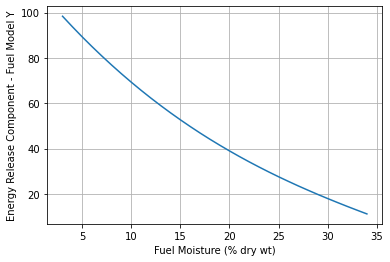

In [13]:
f,ax = plt.subplots()
plt.plot(testfm,erc)
ax.set_xlabel("Fuel Moisture (% dry wt)")
my_label = f'Energy Release Component - Fuel Model {fuelmodel}'
ax.set_ylabel(my_label)
plt.grid()

In [23]:
# Test the sensitivty of ERC to FM1000
erc = []
testval = []
mc.MC1000 = 7
for KBDI in range(0,800):
    res = iCalcIndexes(fm,mc,10,1,1,KBDI,25)
    erc.append(res[0])
    testval.append(KBDI)

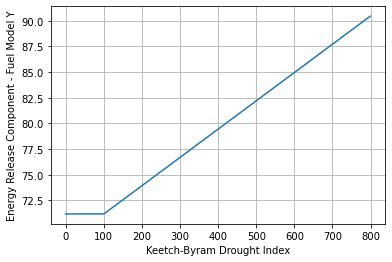

In [24]:
f,ax = plt.subplots()
plt.plot(testval,erc)
ax.set_xlabel("Keetch-Byram Drought Index")
my_label = f'Energy Release Component - Fuel Model {fuelmodel}'
ax.set_ylabel(my_label)
plt.grid()

In [17]:
del mc

In [ ]:
fm.DROUGHT 